In [6]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd

from utils import *

## Data

In [7]:
df = pd.read_csv('data/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [8]:
df.Id.value_counts().head()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

In [9]:
(df.Id == 'new_whale').mean()

0.3810575292772367

In [10]:
(df.Id.value_counts() == 1).mean()

0.4141858141858142

In [11]:
df.Id.nunique()

5005

In [12]:
df.shape

(25361, 2)

In [13]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [14]:
SZ = 224
BS = 64
NUM_WORKERS = 12
SEED=0

In [15]:
data = (
    ImageItemList
        .from_folder('data/train-extracted-224')
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path.name])
        .add_test(ImageItemList.from_folder('data/test-extracted-224'))
        .transform(get_transforms(do_flip=False, max_zoom=1, max_warp=0, max_rotate=2), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
)

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
w_733e9cc, w_b385045, w_94f4850, w_702f2a0, w_181ab06...
  if getattr(ds, 'warn', False): warn(ds.warn)


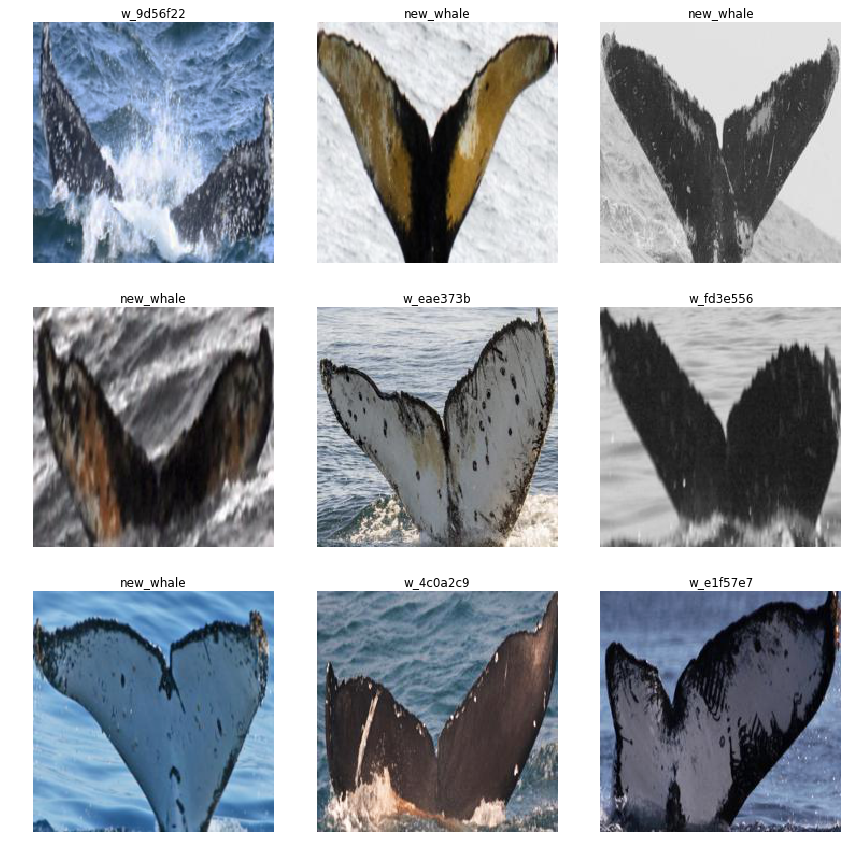

In [16]:
data.show_batch(rows=3)

In [17]:
name = f'res50-{SZ}'

In [18]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5])

In [21]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,map5
1,5.830978,4.772008,0.441550,0.464780
2,5.027474,4.516542,0.455779,0.487369


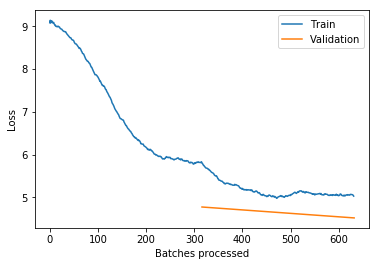

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.save(f'{name}-stage-1')

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


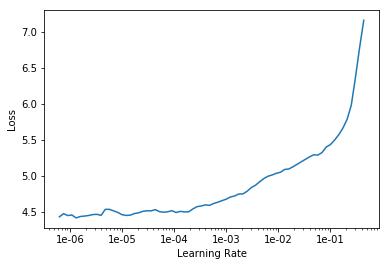

In [26]:
learn.recorder.plot()

In [27]:
max_lr = 1e-4
lrs = [max_lr / 100, max_lr / 10, max_lr]

In [28]:
learn.fit_one_cycle(5, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,4.680285,4.480098,0.458844,0.490889
2,4.559818,4.393840,0.465193,0.499792
3,4.370477,4.325979,0.471760,0.507958
4,4.156468,4.298930,0.475044,0.511694
5,4.104737,4.292633,0.475919,0.512033


In [29]:
learn.save(f'{name}-stage-2')

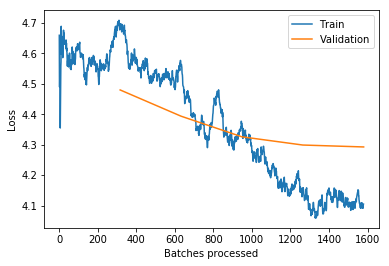

In [30]:
learn.recorder.plot_losses()

In [31]:
preds, _ = learn.get_preds(DatasetType.Test)

In [32]:
mkdir -p subs

In [34]:
def create_submission(preds, data, name, no_bbox_test_images,classes=None):
    if not classes: classes = data.classes
    images = [path.name for path in data.test_ds.x.items]
    images.extend(no_bbox_test_images)
    
    sub = pd.DataFrame({'Image': images})
    print('hello')
    top5 = top_5_pred_labels(preds, classes)
    top5.extend([' '.join(['new_whale', 'new_whale','new_whale','new_whale','new_whale']) for n in no_bbox_test_images])
    sub['Id'] = top5
    sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [35]:
no_bbox_test_images = ['6a72d84ca.jpg']
create_submission(preds, learn.data, name, no_bbox_test_images)

hello


In [36]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,Image,Id
0,a3e2f1961.jpg,new_whale w_7e2eb3d w_9c506f6 w_f0eddab w_60ce6fc
1,67cb588bb.jpg,w_91cc02c w_488865e w_bfe77d0 w_9c506f6 w_60cf87c
2,519db8bd9.jpg,new_whale w_9b5109b w_789c969 w_f0fe284 w_9438119
3,1e5d52a28.jpg,w_04003e9 w_a9304b9 w_1f1cee1 w_d6f0be4 w_5c51475
4,809da6dd7.jpg,new_whale w_191bce3 w_bfcad53 w_700ebb4 w_4bf625b


In [39]:
pd.read_csv(f'subs/{name}.csv.gz').tail

<bound method NDFrame.tail of               Image                                                 Id
0     a3e2f1961.jpg  new_whale w_7e2eb3d w_9c506f6 w_f0eddab w_60ce6fc
1     67cb588bb.jpg  w_91cc02c w_488865e w_bfe77d0 w_9c506f6 w_60cf87c
2     519db8bd9.jpg  new_whale w_9b5109b w_789c969 w_f0fe284 w_9438119
3     1e5d52a28.jpg  w_04003e9 w_a9304b9 w_1f1cee1 w_d6f0be4 w_5c51475
4     809da6dd7.jpg  new_whale w_191bce3 w_bfcad53 w_700ebb4 w_4bf625b
5     b477baa0e.jpg  w_af367c3 w_0135f5f new_whale w_2b069ba w_778e474
6     6edd9cd41.jpg  new_whale w_a190a88 w_16df050 w_36bbd71 w_7e2eb3d
7     03ceb64ce.jpg  new_whale w_bc285a6 w_0bc078c w_4bf625b w_3057209
8     e9844c344.jpg  new_whale w_7e2eb3d w_8f1069a w_bfcad53 w_4441671
9     8c4d9e49c.jpg  new_whale w_a190a88 w_7e56d66 w_8f1069a w_b44e89d
10    2b2a08f4f.jpg  new_whale w_e2a09d4 w_d405854 w_7d458aa w_5773c71
11    6c986262b.jpg  new_whale w_2b65b34 w_b9e5911 w_60cf87c w_accb0cb
12    5402ecfe8.jpg  new_whale w_3de579a w_5a26

In [40]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 126k/126k [00:05<00:00, 22.9kB/s]
Successfully submitted to Humpback Whale Identification

In [37]:
pd.read_csv(f'subs/{name}.csv.gz').shape

(7960, 2)